## Classes for Kernels
Classes for Covariance Kernels. They all inherit from one abstract class, which contains methods they all should have.
Also has a factory method, which can be used for producing the instance of the wished class.

In [114]:
import numpy as np
from scipy.special import kv as kv # Import Bessel Function
from scipy.integrate import quad # Import function to do the integral
from scipy.special import erfc
from time import time
import matplotlib.pyplot as plt
%matplotlib notebook

In [49]:
class Kernel(object):
    '''The Class for the Kernels.
    At least should have a calc_kernel method that calculates the 
    Covariance Matrix '''
    nr_parameters=0  # The Number of Parameters to optimize
    
    def __init__(self):
        print("Sets the parameters of the respective Kernel")
    
    def calc_kernel(self,coords):
        print("Not Implemented: Implement this you lazy shit.")
        
    def set_parameters(self):
        print("Not Implemented: Method to set the parameters. Takes list as input")
        
    def give_nr_parameters(self):
        print("Not Implemented: Method that returns number of Parameters")
        
    def give_parameter_names(self):
        print("Not Implemented: Gives List of Names of Parameters")
        
    def give_parameters(self):
        print("Not Implemented: Returns List of Parameters Values")

In [79]:
class DiffusionBarrierK(Kernel):
    '''A whole class which is designed to 
    calculate covariance kernels from the Barrier Diffusion Model
    It assumes Diffusion along x- and y- axis; with a Barrier at x=0
    Numerically integrates what f should be.
    Throughout y is the STARTING point and x the end point'''
    # Parameters of the Covariance
    nr_parameters=5
    k = 0.5         # Permeability of the Barrier
    D = 1.0         # Diffusion Constant; equals sigma**2. Sets how quickly stuff decays
    mu = 0.001      # Long Distance/Migration rate; sets the max. scale of identity
    t0 = 1          # Starting Point of Integration; i.e. where to start integration. Sets the "local" scale.
    loc_rate = 1    # Local density; giving the rate of local coalescence.
    
    def __init__(self, k=0.5, D=1, t0=1.0, mu=0.001, loc_rate = 1):
        '''Initialize to set desired values!'''
        self.k = k   # Sets the constaints to their required values
        self.D = D
        self.t0 = t0
        self.mu = mu
        self.loc_rate = loc_rate
        
    def set_parameters(self, params=[0.5,1.0,0.001,1,1]):
        assert(len(params)==self.nr_parameters) # Check whether right length
        self.k = params[0]
        self.D = params[1]
        self.t0 = params[2]
        self.mu = params[3]
        self.loc_rate = params[4]
        
    def give_nr_parameters(self):
        return(5)
    
    def give_parameter_names(self):
        return(["k","D","mu","t0","loc_rate"])
        
    def give_parameters(self):
        return([self.k, self.D, self.t0, self.mu, self.loc_rate]) 
    
    def GS(self, t, y, x):
        '''1D Diffusion for same side of the Barrier'''
        n1 = np.exp(-(x-y)**2/(4*self.D*t)) + np.exp(-(x+y)**2/(4*self.D*t))
        d1 = np.sqrt(4*np.pi*self.D*t)
        
        a2 = self.k/self.D * np.exp(2*self.k/self.D * (y+x+2*self.k*t))
        b2 = erfc((y+x+4*self.k*t)/(2*np.sqrt(self.D*t)))
        res=n1/d1 - a2*b2
        if np.isnan(res) or np.isinf(res):    # Check if numerical instability
            return self.gaussian(t,y,x) # Fall back to Gaussian (to which one converges)
        else: return res

    def GD(self, t, y, x):
        '''1D Diffusion for different sides of the Barrier'''
        a1=self.k/self.D*np.exp(2*self.k/self.D * (y-x+2*self.k*t))
        b1=erfc((y-x+4*self.k*t)/(2*np.sqrt(self.D*t)))
        res= a1*b1
        if np.isnan(res) or np.isinf(res):    # Check if numerical instability
            return self.gaussian(t,y,x) # Fall back to Gaussian (to which one converges)
        else: return res

    def gaussian(self, t, y, x):
        '''The normal thing without a barrier'''
        return np.exp(-(x-y)**2/(4*self.D*t)) / np.sqrt(4*np.pi*self.D*t)

    def gaussian1d(self, t, dy):
        '''The One Dimensional Gaussian. 
        Differnce: Here dy notes the difference along the y axis'''
        return 1.0/np.sqrt(4*np.pi*self.D*t) * np.exp(- dy**2 /(4*self.D*t))

    def integrand_barrier_ss(self, t, dy, x0, x1):
        '''The integrand in case there is no barrier
        Product of 1d Gaussian along y-Axis and x-Axis Barrier Pdf.
        And a term for the long-distance migration'''
        return (self.gaussian1d(t, dy) * self.GS(t, x0, x1) * np.exp(-2*self.mu*t))

    def integrand_barrier_ds(self, t, dy, x0, x1):
        '''the integrand for cases of different sided of the barrier.
        Product of 1d Gaussian along y-Axis
        And a term for the long-distance migration'''
        return (self.gaussian1d(t, dy) * self.GD(t,x0, x1) * np.exp(-2*self.mu*t))
        

    def num_integral_barrier(self, dy, x0, x1):
        '''Calculate numerically what the identity 
        due to shared ancestry should be. 
        dy: Difference along y-Axis
        x0: Starting point on x-Axis 
        x1: Ending point on x-Axis
        Integrate from t0 to Infinity'''  
        if x0<0:   # Formulas are only valid for x0>0; but simply flip at barrier if otherwise!
            x0=-x0
            x1=-x1
        
        if x1>0:  # Same side of Barrier
            return self.loc_rate * quad(self.integrand_barrier_ss, 
                self.t0, np.inf, args=(dy, x0, x1))[0] 
        
        if x1<0: # Different side of Barrier
            return self.loc_rate * quad(self.integrand_barrier_ds,
                self.t0, np.inf, args=(dy, x0, x1))[0]
   
    def calc_kernel_mat(self, coords):
        '''Given List of Coordinates; calculate the full covariance Kernel'''
        kernel_mat = [[self.num_integral_barrier(i[1]-j[1], 
                            i[0], j[0]) for i in coords] for j in coords]
        return np.array(kernel_mat)

In [86]:
class DiffusionK(Kernel):
    '''A whole class which is designed to 
    calculate covariance kernels from the simple Diffusion Model
    It assumes Diffusion along x- and y- axis; with a Barrier at x=0
    Numerically integrates what f should be.
    Throughout y is the STARTING point and x the end point'''
    # Parameters of the Covariance
    nr_parameters=4
    D = 1.0         # Diffusion Constant; equals sigma**2. Sets how quickly stuff decays
    mu = 0.001      # Long Distance/Migration rate; sets the max scale of identity
    t0 = 1          # Starting Point of Integration; i.e. where to start integration. Sets the minimum "local" scale.
    loc_rate = 1.0    # Local density; giving the rate of local coalescence.
    
    def __init__(self, D=1, t0=1.0, mu=0.001, loc_rate = 1.0):
        '''Initialize to set desired values!'''
        self.D = D
        self.t0 = t0
        self.mu = mu
        self.loc_rate = loc_rate
        
    def set_parameters(self, params=[1.0,0.001,1,1]):
        assert(len(params)==self.nr_parameters) # Check whether right length
        self.D = params[1]
        self.t0 = params[2]
        self.mu = params[3]
        self.loc_rate = params[4]
        
    def give_nr_parameters(self):
        return(4)
    
    def give_parameter_names(self):
        return(["D", "mu", "t0", "loc_rate"])
        
    def give_parameters(self):
        return([self.D, self.t0, self.mu, self.loc_rate]) 
    
    def integrand(self, t, r):
        '''the integrand for cases of no barrier.
        Product of 1d Gaussian along both Axis
        And a term for the long-distance migration'''
        diff=1.0/(4*np.pi*t) * np.exp(-(r**2)/(4*self.D**2 * t)) # Diffusion
        ld_migration=np.exp(-t*2*self.mu)      # Long Distance Migration
        return (diff * ld_migration)
    
    def num_integral(self, r):
        '''Calculate numerically what the identity 
        due to shared ancestry should be. 
        Integrate from t0 to Infinity'''  
        return self.loc_rate * quad(self.integrand, 
            self.t0, np.inf, args=(r))[0]
        
    def calc_kernel_mat(self, coords):
        '''Given List of Coordinates; calculate the full covariance Kernel'''
        dist_mat = np.sqrt(np.sum((coords[:, None] - coords[None, :])**2, axis=2))  # First set up the Distance Matrix
        
        num_integral_v = np.vectorize(self.num_integral)      # Vectorizes the integral; maybe later parallelize
        kernel = num_integral_v(dist_mat)                # Calculate the kernel via vectorized function
        
        return kernel

In [98]:
class RBFBarrierK(Kernel):
    '''Class for the radial base function kernel'''
    # Parameters
    nr_parameters=3
    l = 15      # Length Scale
    a = 0.02    # Absolute Correlation
    c = 0.5     # Set 
    
    def __init__(self, l=15, a=0.02, c=0.5):
        self.l = l
        self.a = a
        self.c = c
    
    def give_nr_parameters(self):
        return 3
        
    def set_parameters(self, params=[15.0,0.02,0.5]):
        '''Method to set Parameters'''
        self.l = params[0]
        self.a = params[1]
        self.c = params[2]
        
    def give_parameters(self):
        return [self.l, self.a, self.c]
    
    def give_parameter_names(self):
        return(["Length Scale", "Absolute Correlation", "Boundary Reduction"])
    
    def calc_kernel(self, coords):
        '''Return Kernel for Individuals at Coords
        Barrier is assumed to be at x=0'''
        x = coords[:, 0]  # Extracts x-coords
        nr_inds= len(x)

        mask = np.array([-1.0, 1.0])

        coords_refl = coords * mask[None,:]  # Reflects the x-Coordinate

        g = np.sign(x)  # Calculates Signum of x
        same_side = (g[:,None] * g + 1) / 2.0  # Whether the x-Values are on the same side

        r_sqrd = np.sum(((coords[:, None] - coords[None, :]) ** 2), axis=2)  # Calculates pairwise Distance
        r_refl_sqrd = np.sum(((coords_refl[:, None] - coords[None, :]) ** 2), axis=2)  # Calculates the reflected Distance 

        # Calculate the normal Kernel:
        cov_mat = self.a * np.exp(-r_sqrd / (2. * self.l ** 2))  # Calculate the co-variance matrix. Added diagonal term
        cov_mat_refl = self.a * np.exp(-r_refl_sqrd / (2. * self.l ** 2))  # Calculate the covariance matrix for reflected coordinates.

        # Introduce the Covariance Function due to complete correlation
        #K1 = sigma_sqrd * np.ones((nr_inds,nr_inds),dtype=tf.float64)

        # Calculate the full Covariance Matrix
        K = same_side * (cov_mat + self.c * cov_mat_refl) + (1 - same_side) * (1 - self.c) * cov_mat
        return K

In [112]:
# Factory Method that produces the Kernel:
def fac_kernel(kernel_type):
    '''Options DiffusionBarrierK, DiffusionK, 
    '''
    if kernel_type == "DiffusionBarrierK":
        return DiffusionBarrierK()
    
    elif kernel_type == "DiffusionK":
        return DiffusionK()
    
    elif kernel_type == "RBFBarrierK":
        return RBFBarrierK()
    
    else:
        raise Exception('Give a valid Kernel - you idiot.')

Parameters: 


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:54: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in double_scalars


['k', 'D', 'mu', 't0', 'loc_rate']
[0.5, 1, 1.0, 0.001, 1]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


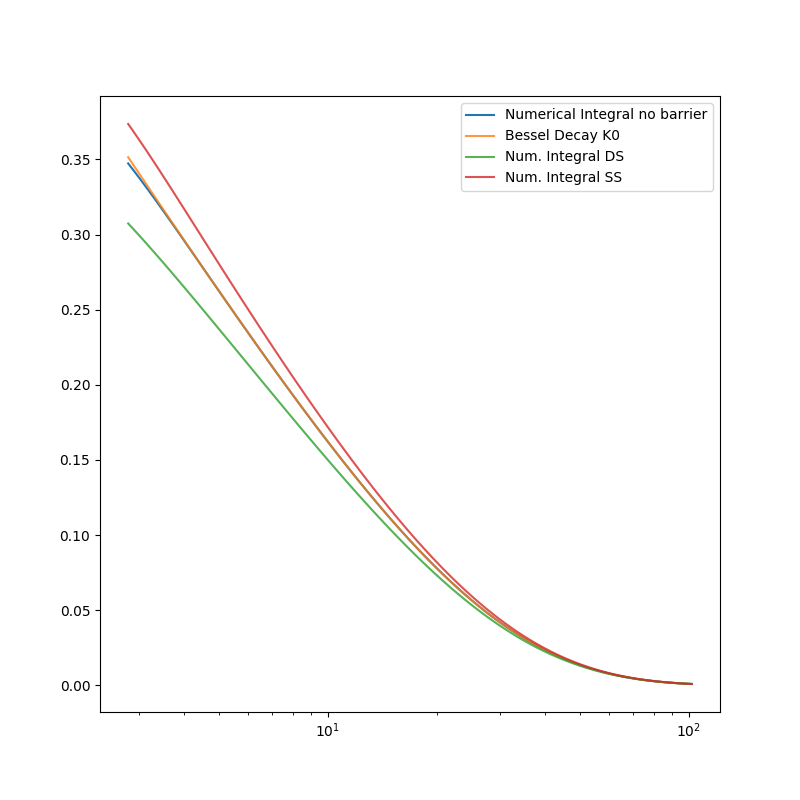

In [96]:
# Test the factory method and everything.
kc = fac_kernel("DiffusionBarrierK")
k0 = fac_kernel("DiffusionK")

print("Parameters: ")
print(kc.give_parameter_names())
print(kc.give_parameters())
mu=kc.give_parameters()[3]   # Set Mutation Rate

x_vec=np.logspace(-0.1,2.0,100)+2
y_vec= [kc.num_integral_barrier(0, -1, -1 + x1) for x1 in x_vec] # 0 Difference along the y-Axis ; 
y_vec2= [kc.num_integral_barrier(0, 1, 1 + x1) for x1 in x_vec] # 0 Difference along the y-Axis ; 
 

y_vec01=np.array([k0.num_integral(r) for r in x_vec]) # Numerical Integral no barrier
#y_vec1=np.array([num_integral(x, t0=1, sigma=sigma, mu=mu) for x in x_vec])
#y_vec20=np.array([num_integral(x, t0=2, sigma=sigma, mu=mu) for x in x_vec])

y_bessel=1/(2*np.pi)*kv(0, np.sqrt(2*mu) * x_vec)   # The numerical Result from Mathematica


plt.figure(figsize=(8,8))
plt.plot(x_vec, y_vec01, label="Numerical Integral no barrier")
plt.plot(x_vec, y_bessel, alpha=0.8, label="Bessel Decay K0")
plt.plot(x_vec,y_vec, alpha=0.8, label="Num. Integral DS")
plt.plot(x_vec,y_vec2, alpha=0.8, label="Num. Integral SS")

plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.show()

In [89]:
# Test Timing:
kc = fac_kernel("DiffusionBarrierK")
%timeit kc.num_integral_barrier(1,10,11)

kc = fac_kernel("DiffusionK")
%timeit kc.num_integral(2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in double_scalars


10 loops, best of 3: 29.1 ms per loop
1000 loops, best of 3: 1.54 ms per loop


<IPython.core.display.Javascript object>


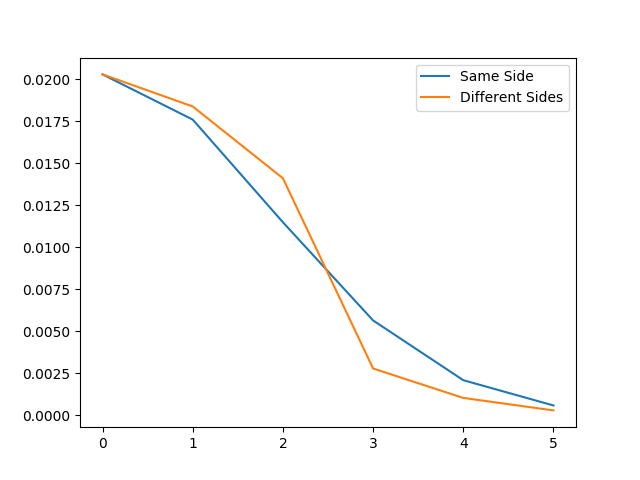

In [110]:
kc = fac_kernel("RBFBarrierK")
coords = np.array([[i,j] for i in xrange(-20,24,8) for j in xrange(-20,24,8)])
kernel = kc.calc_kernel(coords)
plt.figure()
plt.plot(kernel[0,:6], label = "Same Side")
plt.plot(kernel[0,::6], label = "Different Sides")
plt.legend()
plt.show()

In [4]:
import itertools

a = [1,2,3,5,6]

pairlist = []  # Creates List of all Pairs
for combs in itertools.combinations(a, r=2):
    pairlist.append(combs)

print(pairlist)

[(1, 2), (1, 3), (1, 5), (1, 6), (2, 3), (2, 5), (2, 6), (3, 5), (3, 6), (5, 6)]


In [9]:
import numpy as np
a = np.array([1,2])
x0, x1 = a
x0, x1

(1, 2)

For historical Reasons: 
The old reflection RBF Kernel used in the initial script: